# Walmart Sales

We use the data from the Walmart Sales Forecasting competition. We want to predict sales for one week ahead.

In [8]:
import pandas as pd

from darts import TimeSeries
from utils import TimeseriesExperiment, Dataset


DATASET_NAME = "walmart-sales"
ACCELERATOR = "cpu"
DATASET_FOLDER = "data/walmart-sales"
USE_PRETRAINED_MODEL = False

## Load the data

In [9]:
STORE_ID = 1

# Load data
df_train = pd.read_csv(f"{DATASET_FOLDER}/train.csv")
df_features = pd.read_csv(f"{DATASET_FOLDER}/features.csv")
df_stores = pd.read_csv(f"{DATASET_FOLDER}/stores.csv")


def get_dataframe_for_store_id(store_id):
    # Get data from one store
    df = df_train[df_train["Store"] == store_id]
    df = df[df["Dept"] == store_id]

    # Drop redundant columns
    df = df.drop(["Store", "Dept", "IsHoliday"], axis=1)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").resample("W").mean()

    df_features2 = df_features[df_features["Store"] == store_id]
    df_features2 = df_features2.drop(
        ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"], axis=1
    )
    df_features2["Date"] = pd.to_datetime(df_features2["Date"])
    df_features2 = df_features2.set_index("Date").resample("W").mean()

    df = df.join(df_features2, how="left")

    return df


df = get_dataframe_for_store_id(STORE_ID)
df.head()

,Weekly_Sales,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
Date,,,,,,,
2010-02-07,24924.50,1.0,42.31,2.572,211.096358,8.106,0.0
2010-02-14,46039.49,1.0,38.51,2.548,211.242170,8.106,1.0
2010-02-21,41595.55,1.0,39.93,2.514,211.289143,8.106,0.0
2010-02-28,19403.54,1.0,46.63,2.561,211.319643,8.106,0.0
2010-03-07,21827.90,1.0,46.50,2.625,211.350143,8.106,0.0


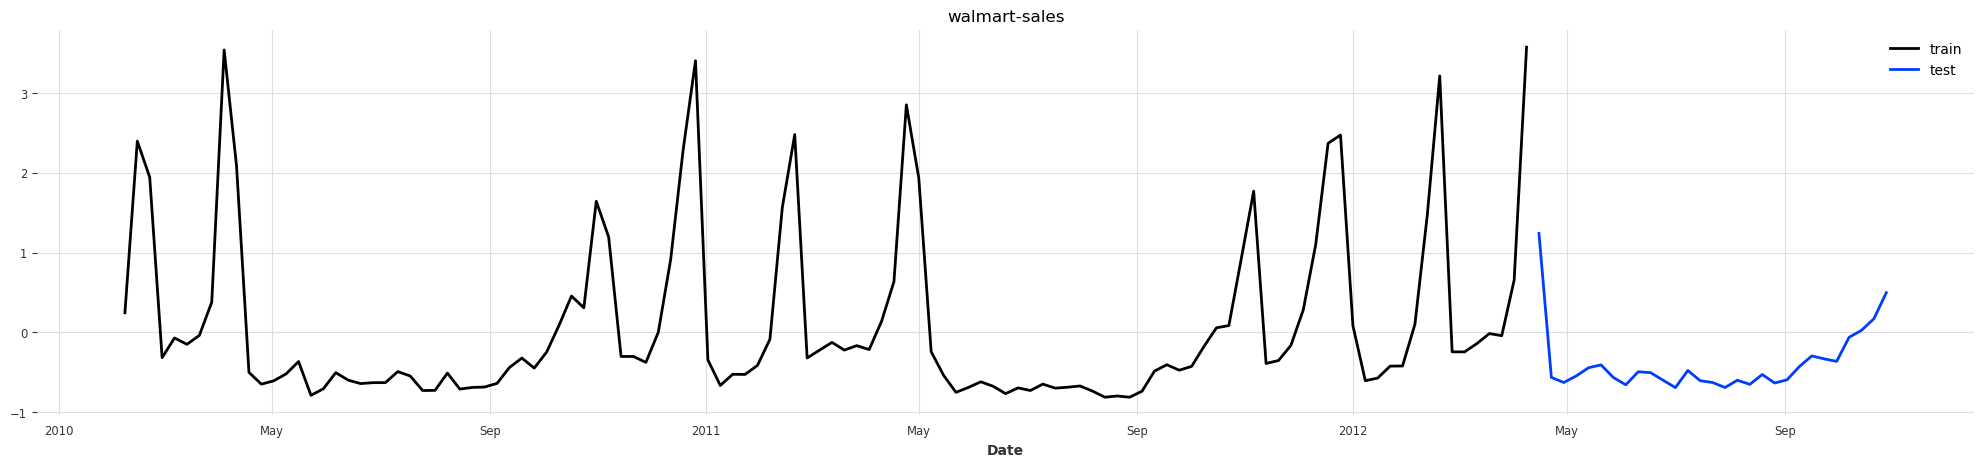

In [10]:
def get_timeseries_from_dataframe(df_):
    df_target = df_["Weekly_Sales"]
    df_past = df_[["Temperature", "Fuel_Price", "CPI", "Unemployment"]]

    df_future = df_["IsHoliday"]

    target = TimeSeries.from_series(df_target, freq="W", fill_missing_dates=True)
    past_covariates = TimeSeries.from_dataframe(
        df_past, freq="W", fill_missing_dates=True
    )
    future_covariates = TimeSeries.from_series(
        df_future, freq="W", fill_missing_dates=True
    )

    return target, past_covariates, future_covariates


def get_dataset_for_store_id(store_id):
    df = get_dataframe_for_store_id(store_id)
    target, past_covariates, future_covariates = get_timeseries_from_dataframe(df)

    dataset = Dataset(
        target,
        "walmart-sales",
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )

    return dataset


# dataset used for hyperparameter tuning
dataset = get_dataset_for_store_id(STORE_ID)
dataset.plot_train_test()

In [11]:
validation_datasets = [get_dataset_for_store_id(i) for i in range(2, 15)]

In [14]:
experiment_params = {
    "dataset": dataset,
    "use_pretrained_model": USE_PRETRAINED_MODEL,
    "validation_datasets": validation_datasets,
}

experiment_params_mini = {
    "dataset": dataset,
    "use_pretrained_model": True,
    "validation_datasets": validation_datasets[:3],
}

## Models

### Baseline

Using GridSearchCV, as no Optuna parameters are specified
No parameters to search


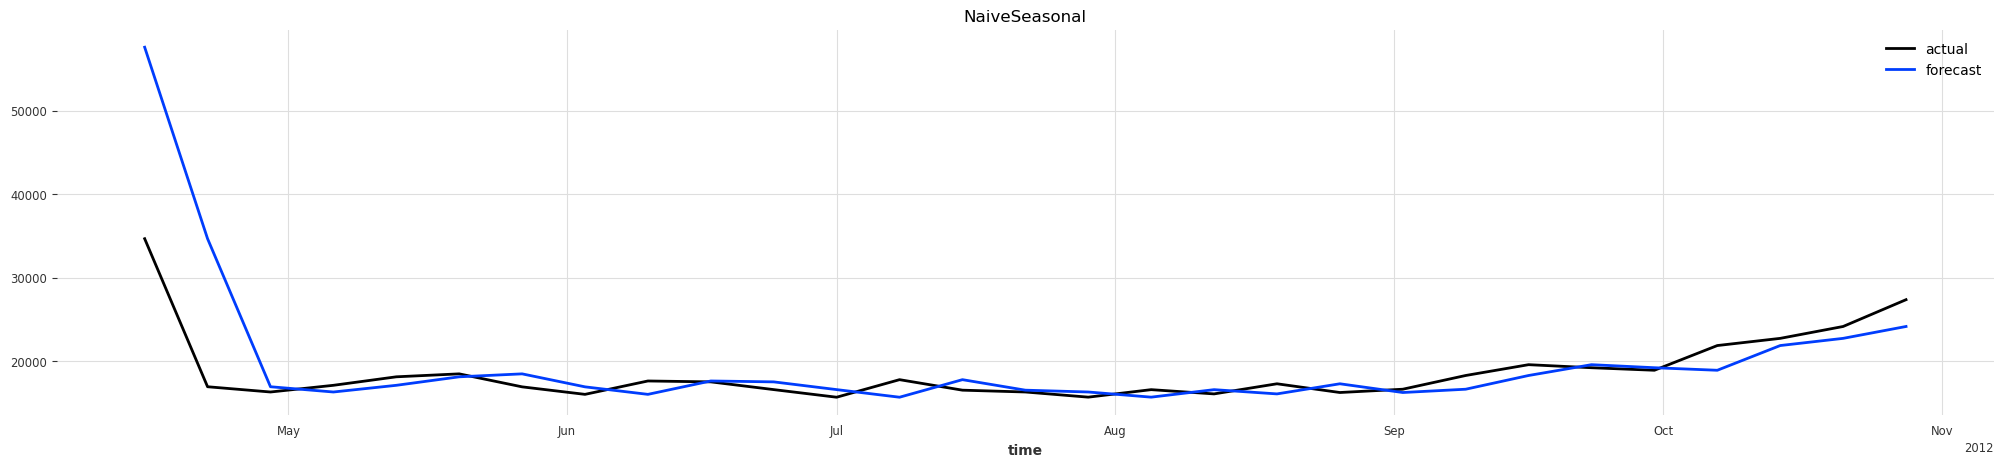

100%|██████████| 13/13 [00:00<00:00, 30.59it/s]


{'mape': 12.026329837631597,
 'mse': 8282745.401761005,
 'rmse': 2630.764195436049,
 'mae': 2013.9509549071615,
 'model': 'NaiveSeasonal',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1717955002.1070158,
 'parameters': OrderedDict([('K', 1)])}

In [6]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=1)

experiment1 = TimeseriesExperiment(
    model,
    retrain=True,
    **experiment_params,
)

experiment1.run()

In [7]:
# arima
from darts.models import ARIMA

model = ARIMA()

experiment2 = TimeseriesExperiment(
    model,
    parameters={"p": [1, 3, 5, 7, 9], "d": [1, 2, 3], "q": [0, 1]},
    retrain=True,
    **experiment_params,
)

experiment2.run()

Using GridSearchCV, as no Optuna parameters are specified
Searching for best parameters {'p': [1, 3, 5, 7, 9], 'd': [1, 2, 3], 'q': [0, 1]}


KeyboardInterrupt: 

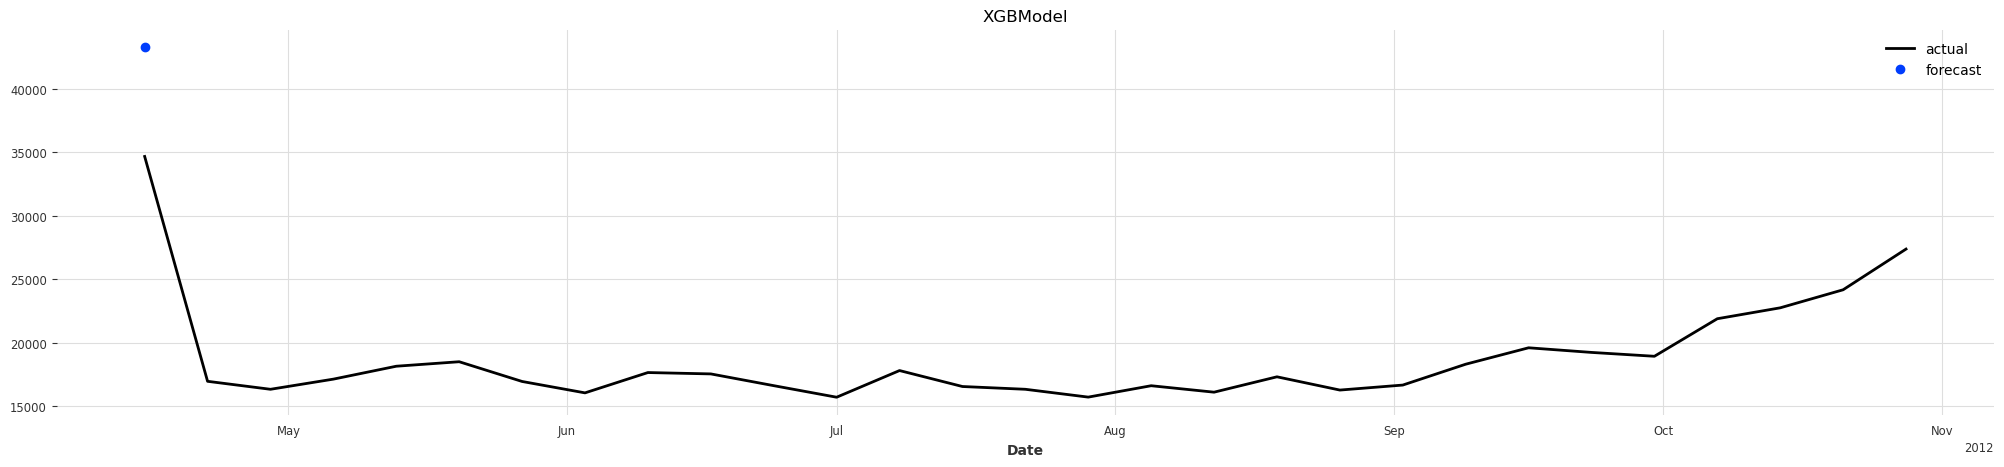

  0%|          | 0/13 [00:00<?, ?it/s]/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
  8%|▊         | 1/13 [00:00<00:01,  8.82it/s]/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn

{'mape': 21.094778778148076,
 'mse': 12132183.774575654,
 'rmse': 2721.755886418269,
 'mae': 2721.755886418269,
 'model': 'XGBModel',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1717951809.112343,
 'parameters': OrderedDict([('lags', 3),
              ('lags_past_covariates', 2),
              ('lags_future_covariates', None),
              ('output_chunk_length', 3),
              ('output_chunk_shift', 0),
              ('add_encoders', None),
              ('likelihood', None),
              ('quantiles', None),
              ('random_state', None),
              ('multi_models', True),
              ('use_static_covariates', True),
              ('max_depth', 3),
              ('n_estimators', 10)])}

In [ ]:
from darts.models import XGBModel

model = XGBModel(
    lags=1,
    lags_past_covariates=1,
)

experiment3 = TimeseriesExperiment(
    model,
    parameters={
        "lags": [3, 7, 14],
        "lags_past_covariates": [1, 2],
        "max_depth": [3, 5],
        "n_estimators": [10, 25, 50],
        "output_chunk_length": [1, 3],
    },
    **experiment_params,
    retrain=False,
)

experiment3.run()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


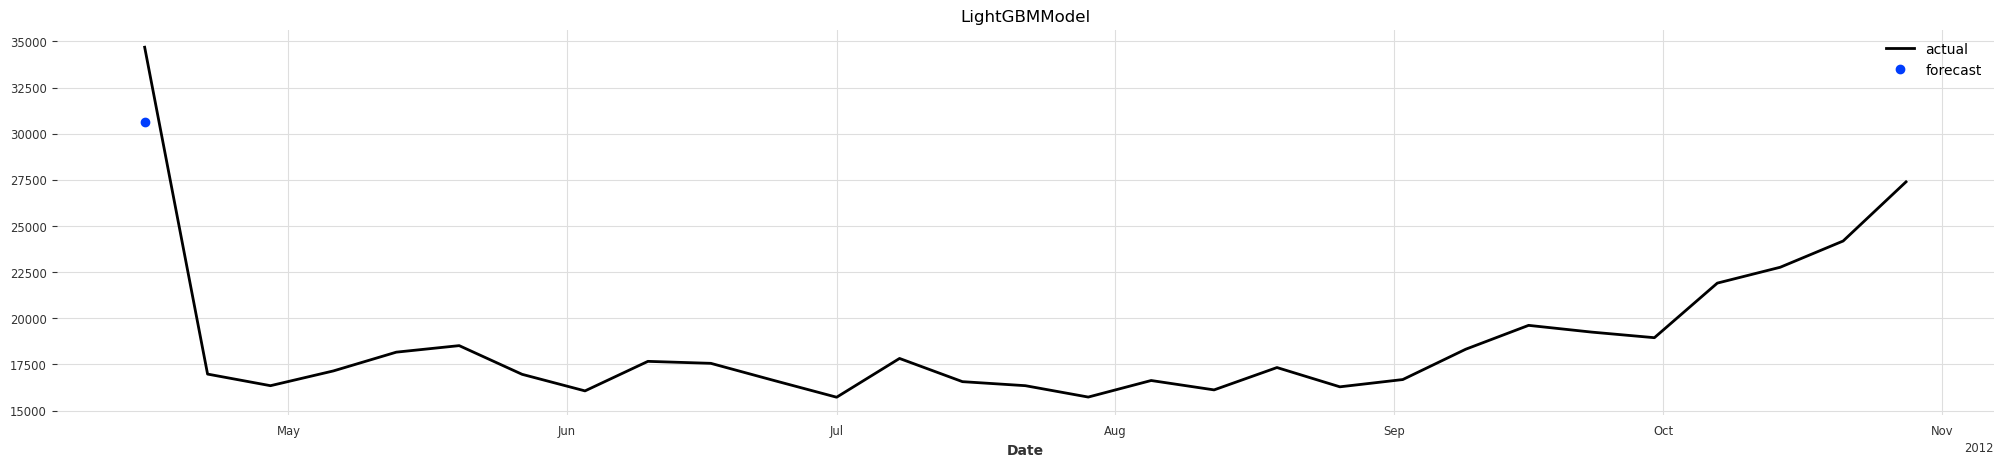

  0%|          | 0/13 [00:00<?, ?it/s]/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be rem

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 5
[LightGBM] [Info] Start training from score -0.025004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

 85%|████████▍ | 11/13 [00:00<00:00, 54.25it/s]/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path wi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 111, number of used features: 5
[LightGBM] [Info] Start training from score 0.036358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

{'mape': 17.80281364298353,
 'mse': 9814620.298784142,
 'rmse': 2542.889510860744,
 'mae': 2542.889510860744,
 'model': 'LightGBMModel',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1717951809.606107,
 'parameters': OrderedDict([('lags', 1),
              ('lags_past_covariates', 1),
              ('lags_future_covariates', None),
              ('output_chunk_length', 3),
              ('output_chunk_shift', 0),
              ('add_encoders', None),
              ('likelihood', None),
              ('quantiles', None),
              ('random_state', None),
              ('multi_models', True),
              ('use_static_covariates', True),
              ('categorical_past_covariates', None),
              ('categorical_future_covariates', None),
              ('categorical_static_covariates', None),
              ('max_depth', 5),
              ('n_estimators', 10)])}

In [ ]:
from darts.models import LightGBMModel

model_lgbm = LightGBMModel(
    lags=1,
    lags_past_covariates=1,
)

experiment4 = TimeseriesExperiment(
    model_lgbm,
    parameters={
        "lags": [1, 4],
        "lags_past_covariates": [1, 2],
        "max_depth": [3, 5, 7],
        "n_estimators": [10, 25, 50],
        "output_chunk_length": [1, 3],
    },
    **experiment_params,
)

experiment4.run()

18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing
18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1]

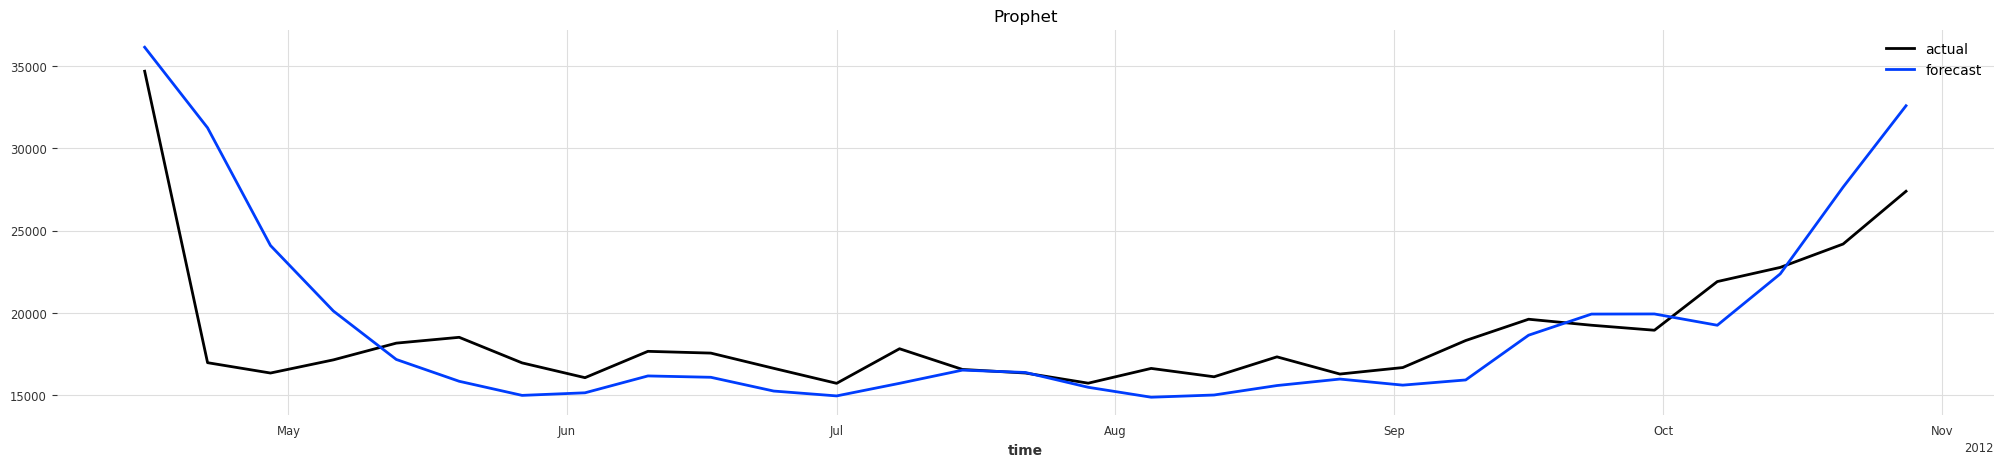

  0%|          | 0/13 [00:00<?, ?it/s]18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
18:50:11 - cmdstanpy - INFO - Chain [1] start processing
1

{'mape': 11.133477766293193,
 'mse': 5012895.757866102,
 'rmse': 2123.6735576388583,
 'mae': 1674.357556127531,
 'model': 'Prophet',
 'forecast_horizon': 1,
 'dataset': 'walmart-sales',
 'experiment_time': 1717951829.289566,
 'parameters': OrderedDict([('add_seasonalities', None),
              ('country_holidays', None),
              ('suppress_stdout_stderror', True),
              ('add_encoders', None),
              ('cap', None),
              ('floor', None)])}

In [ ]:
from darts.models import Prophet

model_prophet = Prophet()

params_prophet = {
    "add_seasonalities": [
        {},
        {"name": "yearly_seasonality", "seasonal_periods": 52, "fourier_order": 5},
    ]
}

experiment_prophet = TimeseriesExperiment(
    model_prophet,
    parameters=params_prophet,
    retrain=True,
    **experiment_params,
)

experiment_prophet.run()

In [ ]:
from darts.models import TFTModel

model_tft = TFTModel(input_chunk_length=16, output_chunk_length=1)

params_fft = {
    "input_chunk_length": [4],
    "output_chunk_length": [1],
    "pl_trainer_kwargs": [{"accelerator": ACCELERATOR}],
}

experiment_tft = TimeseriesExperiment(
    model_tft,
    parameters=params_fft,
    **experiment_params_mini,
)

experiment_tft.run()

In [ ]:
from darts.models.forecasting.rnn_model import RNNModel

lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    input_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={"accelerator": ACCELERATOR},
)

experiment_lstm = TimeseriesExperiment(lstm_model, retrain=True, **experiment_params_mini)

experiment_lstm.run()

## Results

In [16]:
from utils import read_results

df = read_results()
df = df[df["dataset"] == DATASET_NAME]

# print MSE for each model, print millions: 5M, 10M, 15M, etc

for model_name in df["model"].unique():
    model_df = df[df["model"] == model_name]
    mse = model_df["mse"].mean()
    print(f"{model_name}: {mse/1e6:.2f}M")

LightGBMModel: 9.81M
XGBModel: 12.13M
ARIMA: 7.27M
NaiveSeasonal: 8.28M
TFTModel: 10.91M
Prophet: 5.01M
RNNModel: 10.46M


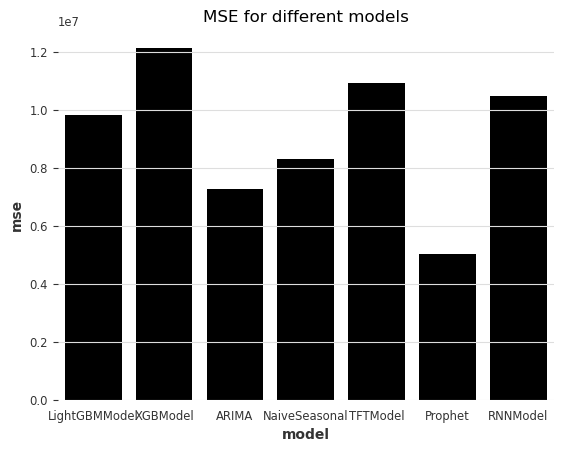

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title("MSE for different models")
sns.barplot(data=df, x="model", y="mse")

plt.savefig(f"results/{DATASET_NAME}/mse.png")

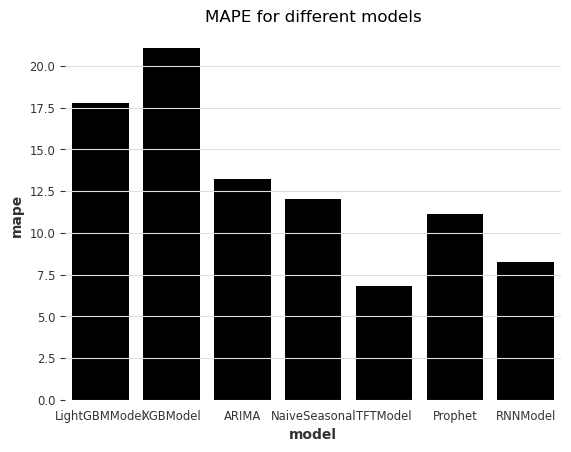

In [18]:
plt.title("MAPE for different models")
sns.barplot(data=df, x="model", y="mape")

plt.savefig(f"results/{DATASET_NAME}/mape.png")